In [1]:
# Clustering algorithm k-means++ style of centroid initialization
# Yonghwan Kim A11746276 | Sangeon Park A11733433

In [2]:
# pyspark install
!pip install pyspark

In [3]:
import random
import os
import numpy as np
import re
import math
from random import randrange
from shutil import copyfile
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt

import sys
from itertools import chain, combinations # iteration tool

from pyspark import SparkContext, SparkConf

from pyspark.sql import functions as f
from scipy.spatial import distance
from operator import add

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# create Spark context with necessary configuration
sc = SparkContext("local","PySpark - CS5683 - Project-3")

In [6]:
# the number of clusters(k)
k = 10
# the number of algorithm interations (I)
iter = 20

In [7]:
# directory to project3
dir = '/content/drive/My Drive/data.txt'

# load data file in numpy format
mat = np.loadtxt(dir)
# number of rows and number of columns
num_rows, num_cols = mat.shape # mat.shape[0] mat.shape[1]
print(num_rows, num_cols)
# number of rows and number of columns after remove duplicates
uniqueMat = np.unique(mat, axis=0)
num_unique_rows, num_unique_cols = uniqueMat.shape 
print(num_unique_rows, num_unique_cols)

# upload matrix to rdd
rdd = sc.parallelize(uniqueMat)
# attach index
irdd = rdd.zipWithIndex()
# change the order of data
irdd = irdd.map(lambda x: (x[1] , x[0]))
irdd.persist()

4601 58
4210 58


PythonRDD[1] at RDD at PythonRDD.scala:53

In [8]:
# datapoint based comparing with centroids
# def squaredEuclideanDistance(x, centroids):
#     distance = []
#     for m in centroids:
#         if m[0] != x[0]:
#             value = np.sum((x[1] - m[1]) ** 2)
#             distance.append(value)
#     if distance:
#         maxUclid = max(distance)
#         # maxUclid = max(distance, key = lambda k: k[0])
#         return maxUclid
#     else:
#         return None

# centroids based comparing with each datapoints
# squared Eculidean distance function
def squaredEuclideanDistance(x, m):
    value = np.sum((x - m) ** 2)
    return value

# initialize the centroids list
centroids = []

# Test case when initial datapoint is 4063
# testlist = irdd.collect()
# for ts in testlist:
#     if ts[0] == 4063:
#         centroids.append(ts)

# Actual Case
# take one random data point for initial centroid
firstCentroid = irdd.takeSample(False, 1)
centroids.append(firstCentroid[0])

print("first random Centroid",centroids[0][0])

# k mean ++ logic starts
# loop until it picks all kth centroids
while len(centroids) != k:
    # -----------------------------------------------------------------------------------------------
    # uncomment to test datapoint based comparison (comment centroids based comparing part)
    # -----------------------------------------------------------------------------------------------
    # datapoint based comparing with centroids
    # nextCentroid = irdd.map(lambda x: (x[0], squaredEuclideanDistance(x, centroids)))
    # resultCent = nextCentroid.collect()
    # removalList = []
    # for r in resultCent:
    #     for c in centroids:
    #         if c[0] == r[0]:
    #             # print("Equal detected.", r, c[0], r[0])
    #             removalList.append(r)
    # resultSetCent = set(resultCent)
    # removalSet = set(removalList)
    # centRemoved = resultSetCent.difference(removalSet)
    # minCent = min(centRemoved, key = lambda t: t[1])
    # -----------------------------------------------------------------------------------------------
    # centroids based comparing with each datapoints
    # uncomment to test centroids based comparison (comment datapoint based comparing part)
    # -----------------------------------------------------------------------------------------------
    recomList = []

    for c in centroids:
        # calculate squared euclidean distance
        nextCentroid = irdd.map(lambda x: (x[0], squaredEuclideanDistance(x[1], c[1])))
        nextCentroidRT = nextCentroid.collect()
        # remove datapoints that are already centroids
        for rc in centroids:
            for nc in nextCentroidRT:
                if rc[0] == nc[0]:
                    nextCentroidRT.remove(nc)
        # find maximum distance datapoints
        maxCent = max(nextCentroidRT, key=lambda x: x[1])
        recomList.append(maxCent)
    # find a minimum distance datapoint from the minimum list
    minCent = min(recomList, key = lambda t: t[1])
    # find the vector from rdd for the matching index
    nn = irdd.filter(lambda x: x[0] == minCent[0])
    centroids.append((minCent[0], nn.collect()[0][1]))
    # -----------------------------------------------------------------------------------------------

for c in centroids:
    print(c[0])

for c in centroids:
    print(c[1])

# initialize cluster list
clusters = []
clusterIndex = 1

# name cluster from 1 to 10 
for centroid in centroids:
    clusters.append((clusterIndex, centroid[1]))
    clusterIndex = clusterIndex + 1
# broadcast clusters for both euclidean and manhattan
euclidean_centroids = sc.broadcast(clusters)
manhattan_centroids = sc.broadcast(clusters)

first random Centroid 1380
1380
3555
1988
3674
2120
2119
93
3229
3907
1646
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 3.000e-01 0.000e+00 0.000e+00 3.000e-01 0.000e+00 1.820e+00
 0.000e+00 0.000e+00 3.000e-01 0.000e+00 6.000e-01 0.000e+00 9.100e-01
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.510e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.210e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.510e+00 0.000e+00 0.000e+00
 5.700e-02 0.000e+00 0.000e+00 0.000e+00 2.310e-01 2.011e+00 2.800e+01
 3.580e+02 0.000e+00]
[1.9000e-01 0.0000e+00 3.8000e-01 0.0000e+00 0.0000e+00 1.9000e-01
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.9000e-01 1.9000e-01
 0.0000e+00 0.0000e+00 0.0000e+00 3.8000e-01 0.0000e+00 1.9000e-01
 1.1400e+00 0.0000e+00 3.8000e-01 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00


In [9]:
# function to calculate euclidean distance
def euclideanDistance(M1, centroids):
    candidates = []
    for m in centroids:
        value = np.sum((M1 - m[1]) ** 2)
        sqED = math.sqrt(value)
        candidates.append((m[0], sqED))
    # find minimum
    centroid = min(candidates, key = lambda k: k[1])
    return centroid
# function to calculate manhattan distance
def manhattanDistance(M1, centroids):
    candidates = []
    for m in centroids:
        value = np.sum(np.absolute(M1 - m[1]))
        candidates.append((m[0], value))
    # find minimum
    centroid = min(candidates, key = lambda k: k[1])
    return centroid
# function to find the next centroid point by calculating mean of clusters
def findCentroid(data):
    a = np.array(data)
    mean = np.mean(a, axis=0)
    return mean
# list of euclidean distribution of clusters
euclidList = []
# list of manhatton distribution of clusters
manhattonList = []
# list of euclidean cost
euclidCostFuncList = []
# list of manhatton cost
manhattonCostFuncList = []

# iterate for 20 times
for i in range(iter):
    # calculate euclidean distances
    euclidRDD = irdd.map(lambda x: (euclideanDistance(x[1], euclidean_centroids.value), x[1]))
    # calculate manhatton distances
    manhattanRDD = irdd.map(lambda x: (manhattanDistance(x[1], manhattan_centroids.value), x[1]))
    # calculate euclidean cost
    euclidCostFunc = euclidRDD.map(lambda x: (x[0][1]) ** 2).reduce(add)
    # calculate manhatton cost
    manhattanCostFunc = manhattanRDD.map(lambda x : x[0][1]).reduce(add)
    euclidCostFuncList.append(euclidCostFunc)
    manhattonCostFuncList.append(manhattanCostFunc)
    euclidNextRDD = euclidRDD.map(lambda x: (x[0][0], x[1]))
    manhattanNextRDD = manhattanRDD.map(lambda x: (x[0][0], x[1]))

    # euclidean
    # find how many datapoints are under which clusters
    euclidTestRDD = euclidNextRDD.groupByKey().map(lambda x : (x[0], len(list(x[1]))))
    euclidGroupRDD = euclidNextRDD.groupByKey().map(lambda x : (x[0], list(x[1])))
    euclidList.append(sorted(euclidTestRDD.collect()))
    # update the centroid
    nextEuclidClusters = euclidGroupRDD.map(lambda x: (x[0], findCentroid(x[1]))).sortBy(lambda x : x[0])
    # broadcast updated centroid
    euclidean_centroids = sc.broadcast(nextEuclidClusters.collect())

    # manhattan
    # find how many datapoints are under which clusters
    manhattanTestRDD = manhattanNextRDD.groupByKey().map(lambda x : (x[0], len(list(x[1]))))
    manhattanGroupRDD = manhattanNextRDD.groupByKey().map(lambda x : (x[0], list(x[1])))
    manhattonList.append(sorted(manhattanTestRDD.collect()))
    # update the centroid
    nextManhattanClusters = manhattanGroupRDD.map(lambda x: (x[0], findCentroid(x[1]))).sortBy(lambda x : x[0])
    # broadcast updated centroid
    manhattan_centroids = sc.broadcast(nextManhattanClusters.collect())

print("Euclidean")
for e in euclidList:
    print(e)
print("Manhattan")
for m in manhattonList:
    print(m)

print("Euclidean cost")
for e in euclidCostFuncList:
    print(e)
print("Manhattan cost")
for m in manhattonCostFuncList:
    print(m)

Euclidean
[(1, 4123), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 79)]
[(1, 4073), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 7), (10, 123)]
[(1, 3999), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 40), (10, 164)]
[(1, 3907), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 49), (10, 247)]
[(1, 3830), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 61), (10, 312)]
[(1, 3780), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 75), (10, 348)]
[(1, 3736), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 83), (10, 384)]
[(1, 3704), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 85), (10, 413)]
[(1, 3679), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 2), (9, 85), (10, 437)]
[(1, 3659), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 8), (9, 79), (10, 457)]
[(1, 3653), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 27), (9, 62), (10, 461)]
[(1, 3641), (2, 1), (3, 

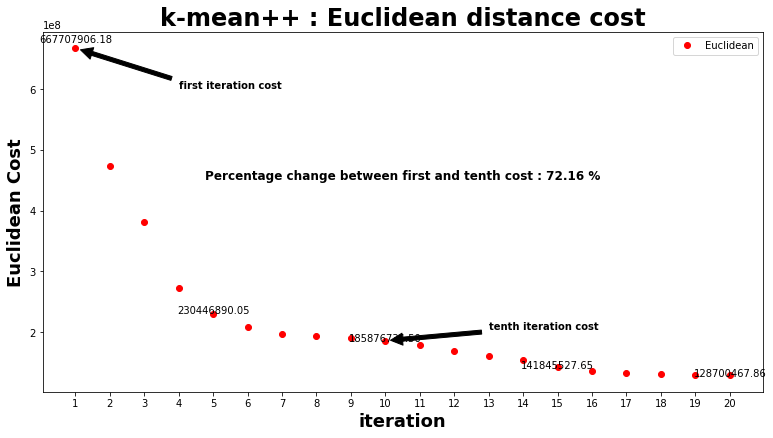

In [10]:
xpoint= np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# input
eu_ypoint = np.array(euclidCostFuncList)
def percentage_change(first, tenth):
  return (first-tenth)/first
# text component of Percentage change between first and tenth cost
firstandtenth = 'Percentage change between first and tenth cost : %.2f'%(percentage_change(eu_ypoint[0],eu_ypoint[9])*100)+" %"

#set the graph size
fig = plt.figure(figsize=(10, 5))
# scale setting
ax = fig.add_axes([0, 0, 1, 1])
# title
ax.set_title('k-mean++ : Euclidean distance cost', fontsize=24, fontweight='bold')
# show exact number of what xpoint have
ax.set_xticks(xpoint)
# x label
ax.set_xlabel('iteration', fontsize=18, fontweight='bold')
# y label
ax.set_ylabel('Euclidean Cost', fontsize=18, fontweight='bold')
# plot
ax.plot([xpoint],[eu_ypoint],'ro')
# legend
ax.legend(['Euclidean'])
fig.text(0.5,0.6,firstandtenth,horizontalalignment='center',verticalalignment='center',fontsize=12,fontweight='bold')
# annotation for first iteration cost and tenth iteration cost
for i,j in zip(xpoint,eu_ypoint):
    if i%5==0 or i== 1:
      new_j = "{:.2f}".format(j)
      ax.annotate(new_j,xy=(i,j),xytext=(i,j+j*0.02),horizontalalignment='center',verticalalignment='center')
    if i == 1:    
      ax.annotate('first iteration cost',xy=(i,j),xytext=(i+3,j*0.9),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
    if i == 10:
      ax.annotate('tenth iteration cost',xy=(i,j),xytext=(i+3,j*1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')

plt.show()

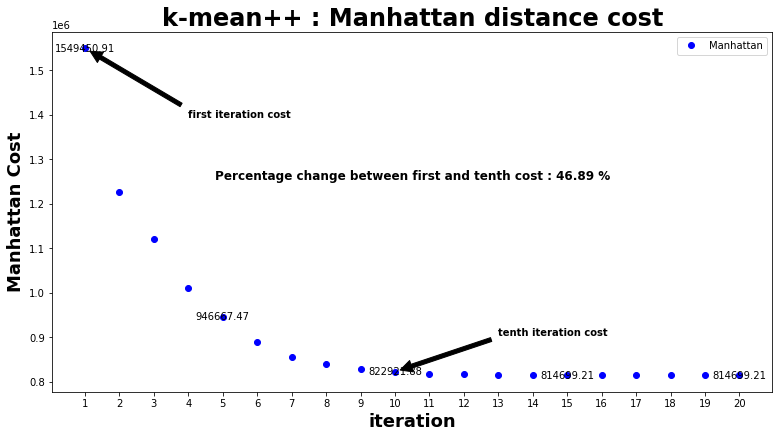

In [11]:
xpoint= np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# input
mh_ypoint = np.array(manhattonCostFuncList)
def percentage_change(first, tenth):
  return (first-tenth)/first
# text component of Percentage change between first and tenth cost
firstandtenth = 'Percentage change between first and tenth cost : %.2f'%(percentage_change(mh_ypoint[0],mh_ypoint[9])*100)+" %"

#set the graph size
fig = plt.figure(figsize=(10, 5))
# scale setting
ax = fig.add_axes([0, 0, 1, 1])
# title
ax.set_title('k-mean++ : Manhattan distance cost', fontsize=24, fontweight='bold')
# show exact number of what xpoint have
ax.set_xticks(xpoint)
# x label
ax.set_xlabel('iteration', fontsize=18, fontweight='bold')
# y label
ax.set_ylabel('Manhattan Cost', fontsize=18, fontweight='bold')
# plot
ax.plot([xpoint],[mh_ypoint],'bo')
# legend
ax.legend(['Manhattan'])
fig.text(0.5,0.6,firstandtenth,horizontalalignment='center',verticalalignment='center',fontsize=12,fontweight='bold')
# annotation for first iteration cost and tenth iteration cost
for i,j in zip(xpoint,mh_ypoint):
    if i%5==0 or i== 1:
      new_j = "{:.2f}".format(j)
      ax.annotate(new_j,xy=(i,j),xytext=(i,j),horizontalalignment='center',verticalalignment='center')
    if i == 1:    
      ax.annotate('first iteration cost',xy=(i,j),xytext=(i+3,j*0.9),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')
    if i == 10:
      ax.annotate('tenth iteration cost',xy=(i,j),xytext=(i+3,j*1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=10,fontweight='bold')

plt.show()

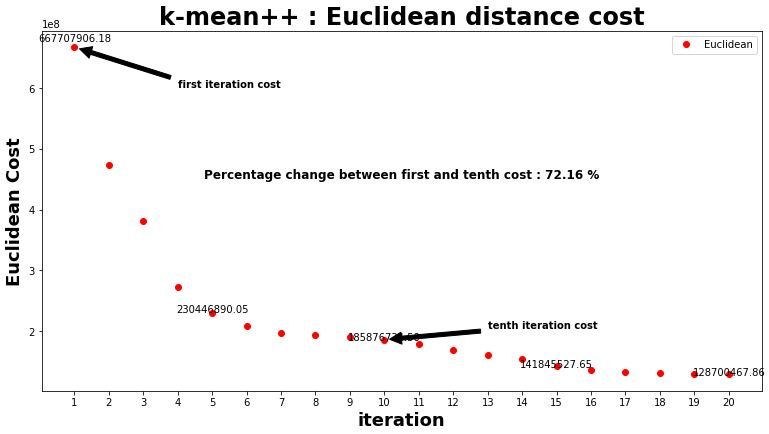

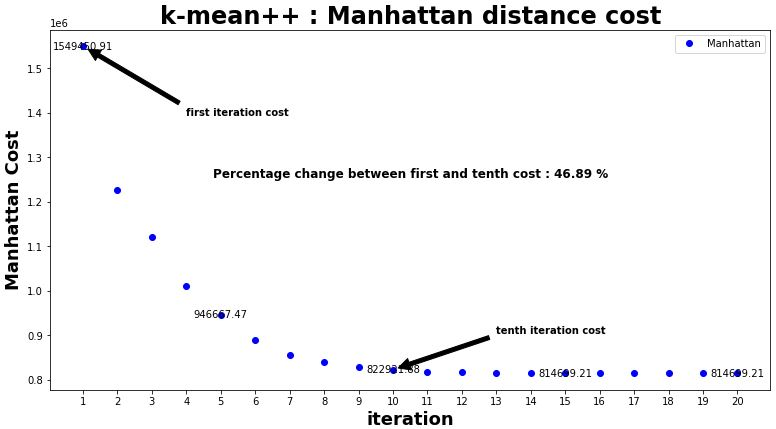

#Report: compare performance of cost functions

The plots of both Euclidean distance cost and Manhatton distance cost indicate that it is converging to some level after few iteration steps. Also, euclidean distance square the distance and square root the equation later between each data points which makes the cost high. However, manhatton distance does have those sequence which makes the cost lower compare to euclidean distance. The percentage change between first and tenth cost of both distance plot shows that euclidean plot drops more significantly by 72.16 % than manhatton plot by 46.89 %. This means that euclidean is converging faster than manhatton equation does.  

#Report: compare performance of two programs (k-mean VS k-mean++)



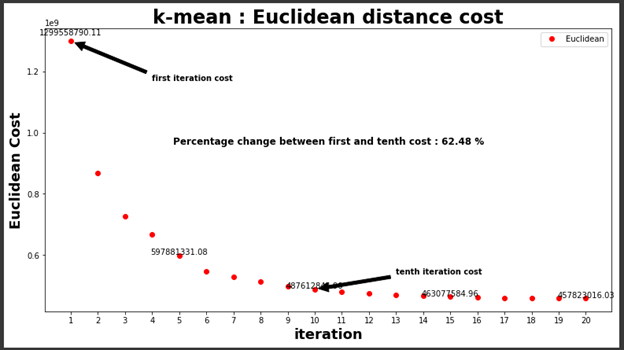

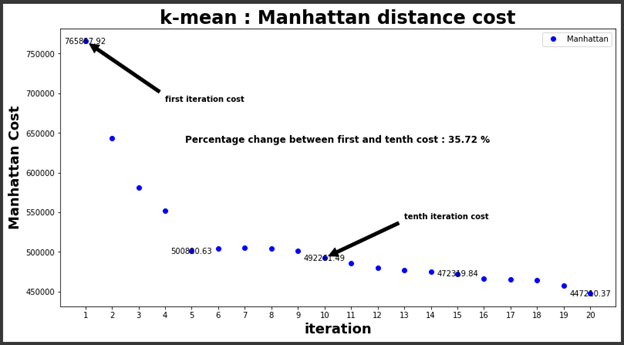

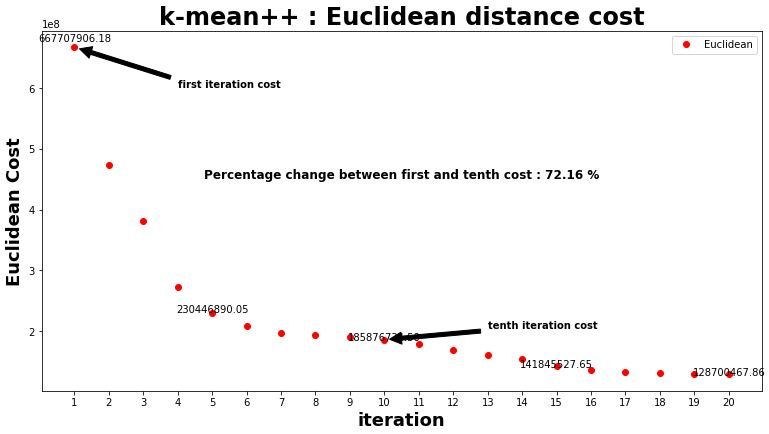

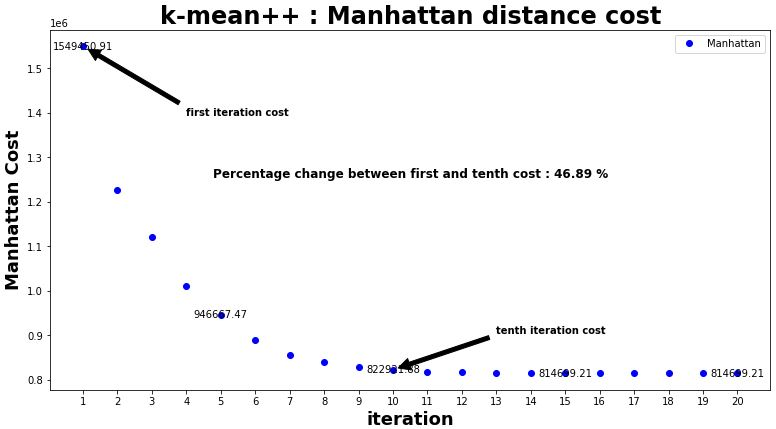


K-mean: euclidean 62.48 % VS K-mean++: euclidean 72.16 %
K-mean: manhatton 35.72 % VS K-mean++: manhatton 46.89 %

The percentage difference between K-mean and K-mean++ shows that Euclidean cost and Manhatton cost of K-mean++ are dropping 9.68 % and 11.17 % faster respectivly with the test case we had. The reason that K-mean++ has better performance is that it takes better initial centroids that are well distributed by their distance unlike K-mean, which takes random initial centroids.


# Participation Report

Sangeon Park:

K-mean Centroids selection,
K-mean euclidean distance,
K-mean manhatton distance,
K-mean euclidean cost function,
K-mean manhatton cost function,
Ploting for both K-mean and K-mean++,
Writing K-mean Report

Yonghwan Kim:

K-mean++ Centroids selection,
K-mean++ square euclidean distance,
K-mean++ euclidean distance,
K-mean++ manhatton distance,
K-mean++ euclidean cost function,
K-mean++ manhatton cost function,
Writing K-mean++ Report